In [ ]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, generated_jit

import sklearn

import os
import math

%matplotlib inline
import random
random.seed(7801)
import timeit


from scipy.stats import norm
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR="/content/drive/MyDrive/PDE/Data/"

Mounted at /content/drive


# Black Scholes Base Class

In [ ]:
class BlackScholes:
    @staticmethod
    def EurCall_BS(S,K,tau,sigma,r, q=0):
        d1 = BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        d2 = BlackScholes.d2_BS(S,K,tau,sigma,r,q=0)
        return S*np.exp(-q*tau)*norm.cdf(d1) - K*np.exp(-r*tau)*norm.cdf(d2)
    @staticmethod
    def EurPut_BS(S,K,tau,sigma,r, q=0):
        d1 = BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        d2 = BlackScholes.d2_BS(S,K,tau,sigma,r,q=0)
        return  K*np.exp(-r*tau)*norm.cdf(-d2) - S*np.exp(-q*tau)*norm.cdf(-d1) 
        
    @staticmethod        
    def d1_BS(S,K,tau,sigma,r,q=0):
        d1 = (np.log(S/K) +( r- q + 0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
        return d1
    @staticmethod        
    def d2_BS(S,K,tau,sigma,r,q=0):
        d2 = BlackScholes.d1_BS(S,K,tau,sigma,r,q)-sigma*np.sqrt(tau)
        return d2
    
    @staticmethod       
    def delta_call_BS(S,K,tau,sigma,r,q=0):
        return np.exp(-q*tau)*norm.cdf(BlackScholes.d1_BS(S,K,tau,sigma,r,q=0))   
    @staticmethod       
    def delta_put_BS(S,K,tau,sigma,r,q=0):
        return np.exp(-q*tau)*(norm.cdf(BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)) -1)
    
    @staticmethod       
    def vega_BS(S, K, tau, r, sigma, q=0):
        d1 =  BlackScholes.d1_BS(S,K,tau,sigma,r,q=0)
        return S * norm.pdf(d1) * np.sqrt(tau) * np.exp(-q*tau) 

    @staticmethod
    def impliedVol(marketPrice, S,K,tau,r, q=0, IsCall=True):
        MAX_ITERATIONS = 200
        PRECISION = 1.0e-5
        sigma = 0.5
        for i in range(0, MAX_ITERATIONS):
            if IsCall:
                modelPrice = BlackScholes.EurCall_BS(S,K,tau,sigma,r, q) 
            else:
                modelPrice = BlackScholes.EurPut_BS(S,K,tau,sigma,r, q) 

            vega = BlackScholes.vega_BS(S, K, tau, r, sigma,q)
            diff = marketPrice - modelPrice  # our root
            if (abs(diff) < PRECISION):
                return sigma
            sigma = sigma + diff/vega # f(x) / f'(x)
        return sigma # value wasn't found, return best guess so far

# Heston Mixing Monte Carlos


$$ \frac{dS(t)}{S(t)} = rdt+\sqrt{V(t)}dW_1$$
$$ dV(t) = \kappa(\theta -V(t)) dt+\sigma\sqrt{V(t)}dW_2$$
$$ dW_1 \dot dW_2 = \rho dt $$


In [ ]:
class MixingMC:
  def __init__(self,N,M,S0,V0, kappa, T, theta, sigma, rho, K, r=0,q=0):
    ''' Heston Model '''
    # MonteCarlo.__init__(r,sigma,S0,T,N,M,q)
    self.N  = N 
    self.M = M
    self.S0 = S0
    self.T = T
    self.r = r
    self.q = q
    self.sigma = sigma
    self.dt = T/M
    self.V0 = V0
    self.kappa = kappa
    self.theta = theta
    self.rho = rho
    self.K = K
    self.V = np.zeros((N,M+1))                                  # V(t): V(0) -> V(T)
    self.CallPrice = np.zeros(N)
    self.PutPrice = np.zeros(N)
    self.dWt = self.indepGaussRV((self.N,self.M))*np.sqrt(self.dt)     # Brownian Motion of V(t): dW(0) -> dW(T-dt)
  
  def model(self, V_curr, rv):
      """ SDE of V(t) """
      dV = self.kappa * (self.theta - V_curr)*self.dt + np.sqrt(V_curr)* self.sigma* rv
      V_next = V_curr + dV
      return V_next

  # @jit(nopython=False) 
  def generatePath(self):
      V_curr = np.full(self.N,self.V0)
      self.V[:,0] = V_curr 
      for j in range(1,self.M+1):
          V_curr = self.model(V_curr, self.dWt[:,j-1])        # V(t+1) = model(V(t),dw(t))
          self.V[:,j] = V_curr 

  def BS_Vol_scen(self, v_scen, dW_scen):
      sum_v = v_scen[:-1].sum()
      sum_sqrt_v_dW = (np.sqrt(v_scen[:-1])*dW_scen).sum()
      
      sigma_eff_2 = (1-self.rho**2)*self.dt/self.T * sum_v
      sigma_eff = np.sqrt(sigma_eff_2)
      S0_eff = self.S0*np.exp(-0.5*(self.rho)**2*self.dt*sum_v + self.rho*sum_sqrt_v_dW)
      
      Call = BlackScholes.EurCall_BS(S0_eff,self.K,self.T,sigma_eff,self.r,self.q)
      Put = BlackScholes.EurPut_BS(S0_eff,self.K,self.T,sigma_eff,self.r,self.q)
        
      return Call, Put

  # @jit(nopython=False) 
  def cal_Option_Price(self):
      self.generatePath()
      for i in range(self.N):
          self.CallPrice[i], self.PutPrice[i] = self.BS_Vol_scen(self.V[i,:],self.dWt[i,:])

  def cal_Option_Price2(self):
      self.generatePath()
      sum_v = self.V[:,:-1].sum(1)
      sum_sqrt_v_dW = (np.sqrt(self.V[:,:-1])*self.dWt).sum(1)        # sum[ sqrt(V(t))*dW(t) ]

      sigma_eff_2 = (1-self.rho**2)*self.dt/self.T * sum_v
      self.sigma_eff = np.sqrt(sigma_eff_2)
      self.S0_eff = self.S0*np.exp(-0.5*(self.rho**2)*self.dt*sum_v + self.rho*sum_sqrt_v_dW)

      self.CallPrice = BlackScholes.EurCall_BS(self.S0_eff,self.K,self.T,self.sigma_eff,self.r,self.q)
      self.PutPrice = BlackScholes.EurPut_BS(self.S0_eff,self.K,self.T,self.sigma_eff,self.r,self.q)


  def printPerformance(self):
      print("Call Price: ")
      print(self.stats(self.CallPrice))
      self.hist(self.CallPrice,'Call Price')
      print("Put Price: ")
      print(self.stats(self.PutPrice))
      #self.hist(self.PutPrice,'Put Price')
  

  @staticmethod
  def indepGaussRV(N):
      return np.random.standard_normal(N)
  
  @staticmethod
  def hist(simulation,title=None):
      ax = sns.displot(simulation, color ='g', bins=100, kde=True)
      if title is not None:
        ax.fig.suptitle(title)

      
  @staticmethod
  def stats(simulation):
      mean = np.mean(simulation)
      std = np.std(simulation, ddof=1)
      SE = std/np.sqrt(len(simulation))
      
      return {"Mean": mean ,"Std": std ,"StandardError": SE}
          



## run Mixing MC

In [ ]:

S0 = 100
V0 = 0.5**2
K =  100
kappa = 5
tau = 3/12
theta = 0.35**2    # Long-term Variance
sigma = 0.3        # Vol of Vol
rho = 0.3
lambda_ = 0
r=0.014

N = 100000
M = 1000

Call Price: 
{'Mean': 8.957835349021593, 'Std': 4.337034192392893, 'StandardError': 0.013714906337990452}
Put Price: 
{'Mean': 8.600880417538216, 'Std': 2.458429456573389, 'StandardError': 0.007774236549621916}
Time:  11.991879039000082


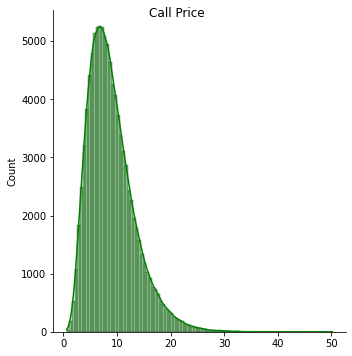

In [ ]:
start = timeit.default_timer()

MMC_obj = MixingMC(N,M,S0,V0, kappa, tau , theta, sigma, rho, K, r,q=0)
MMC_obj.cal_Option_Price2()
MMC_obj.printPerformance()

stop = timeit.default_timer()

print('Time: ', stop - start)  


Sigma_eff: 
{'Mean': 0.4206527260902081, 'Std': 0.02842313128685594, 'StandardError': 8.988183310045745e-05}


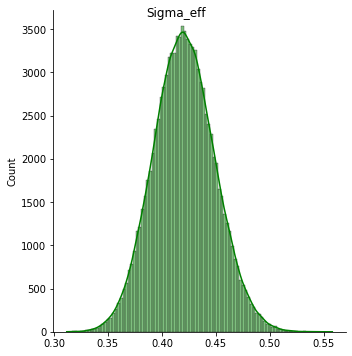

In [ ]:
print("Sigma_eff: ")
print(MixingMC.stats(MMC_obj.sigma_eff))

MixingMC.hist(MMC_obj.sigma_eff,'Sigma_eff')

S0_eff: 
{'Mean': 100.00756671752484, 'Std': 6.693118819904657, 'StandardError': 0.021165500121037042}


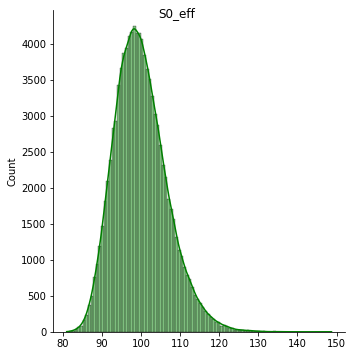

In [ ]:
print("S0_eff: ")
print(MixingMC.stats(MMC_obj.S0_eff))
MixingMC.hist(MMC_obj.S0_eff,'S0_eff')

Call Price: 
{'Mean': 8.947678046805482, 'Std': 4.333899209321727, 'StandardError': 0.013704992651059499}
Put Price: 
{'Mean': 8.608369051412284, 'Std': 2.4608101494348564, 'StandardError': 0.007781764961473457}
Time:  56.007209504


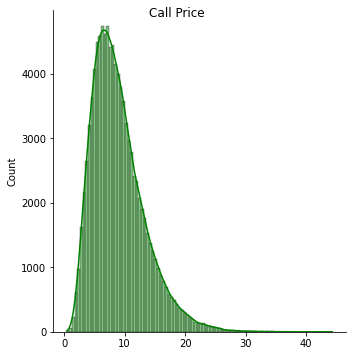

In [ ]:
start = timeit.default_timer()

MMC_obj = MixingMC(N,M,S0,V0, kappa, tau , theta, sigma, rho, K, r,q=0)
MMC_obj.cal_Option_Price()
MMC_obj.printPerformance()

stop = timeit.default_timer()

print('Time: ', stop - start)  


Using np matrix calculation can fasten the program by 5 times

## Check the impact of N and M

In [ ]:
start = timeit.default_timer()

# MMC_obj = MixingMC(N,M,S0,V0, kappa, tau, theta, sigma, rho, K, r=0,q=0)
MMC_obj = MixingMC(1000,M,S0,V0, kappa, tau, theta, sigma, rho, K, r=0,q=0)
MMC_obj.cal_Option_Price()
MMC_obj.printPerformance()

stop = timeit.default_timer()

print('Time: ', stop - start)  


Call Price: 
{'Mean': 8.965748680236997, 'Std': 4.336792336552949, 'StandardError': 0.013714141522670817}
Put Price: 
{'Mean': 8.595356752193839, 'Std': 2.4579717589247503, 'StandardError': 0.007772789182572514}
Time:  12.202198345999989
Call Price: 
{'Mean': 8.964385176335984, 'Std': 4.32366347504482, 'StandardError': 0.013672624417220216}
Put Price: 
{'Mean': 8.592616030124406, 'Std': 2.4490502145954, 'StandardError': 0.007744576782245607}
Time:  11.451411911999998
Call Price: 
{'Mean': 8.939876115985653, 'Std': 4.332464965384653, 'StandardError': 0.013700457173498057}
Put Price: 
{'Mean': 8.61353049589003, 'Std': 2.4600126249580185, 'StandardError': 0.007779242967636915}
Time:  11.686481006000008
Call Price: 
{'Mean': 8.956603213708563, 'Std': 4.319561220277805, 'StandardError': 0.013659651948614166}
Put Price: 
{'Mean': 8.59766879681985, 'Std': 2.4489248350730977, 'StandardError': 0.007744180297383189}
Time:  11.262272631000002
Call Price: 
{'Mean': 8.93588393503202, 'Std': 4.32704

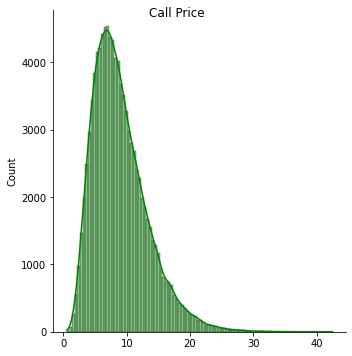

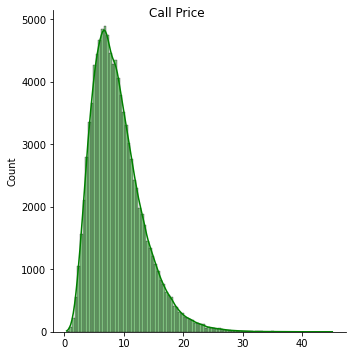

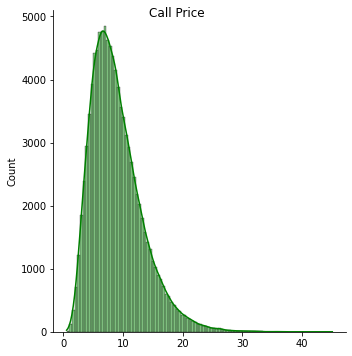

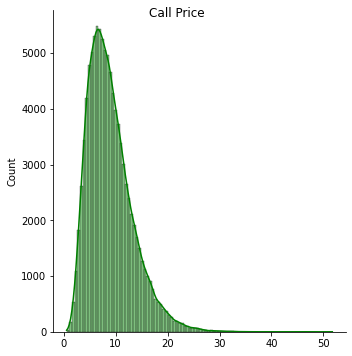

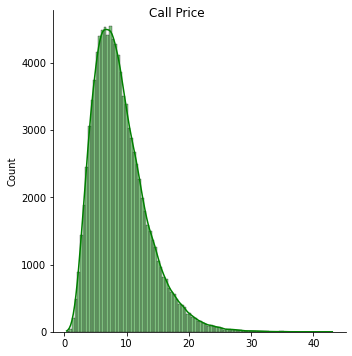

In [ ]:
for m in [10,50,100,500,1000]:
  start = timeit.default_timer()

  # MMC_obj = MixingMC(1000000,m,S0,V0, kappa, tau, theta, sigma, rho, K, r=0,q=0)
  MMC_obj = MixingMC(N,M,S0,V0, kappa, tau , theta, sigma, rho, K, r,q=0)
  MMC_obj.cal_Option_Price2()
  MMC_obj.printPerformance()

  stop = timeit.default_timer()

  print('Time: ', stop - start)  